#Descrizione

In questo notebook vengono testati diversi metodi per fare interpolazione dalla libreria `cv2`.

Modello su database da 18800; rete bidirezionale LSTM (CuDNN).

Parametri:

1.   2 layer da 141 nodi, 94 nodi;
2.   Immagini 64x64;
3.   1024 batch size;

(Patience = 5).

Eseguo lo stesso modello con diverse funzioni di interpolazione.

Interpolazioni e val_accuracy raggiunta:

*  INTER_NEAREST (0) – 92.8%, 48 epoche
*  INTER_LINEAR (1) – 93.5%, 71 epoche
*  INTER_AREA (2) – 91,4%, 66 epoche
*  INTER_CUBIC (3) – 92.2%, 61 epoche
*  INTER_LANCZOS4 (4) – 92,2%, 65 epoche


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Import

In [2]:
import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

import cv2

#Data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, os.path

#Per modello NN
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dropout

import time
import math

print(tf.__version__)

1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Defining methods

In [3]:
class Stats:

  def __init__( self, img_dim, perc_used, batch_size_used, 
                val_acc, val_loss, total_epochs,
                early_stopping_epochs, total_time, modello, history, _for_conf_matr, model_name):
    
    self.model = modello
    self.history = history

    self._for_conf_matr = _for_conf_matr

    self.img_dim = img_dim           
    self.perc = str(perc_used)
    self.batch_size = str(batch_size_used)
    
    self.val_acc = str(round(val_acc, 5))
    self.val_loss = str(round(val_loss, 5))

    self.total_epochs = str(total_epochs)
    self.early_stopping_epochs = str(early_stopping_epochs)
    self.training_time = str(round(total_time, 5))
    self.model_name = model_name

  def myStats(self):
    print("Dimensione immagini: ", self.img_dim)
    print("Percentuale test set: " + self.perc + "%")
    print("Dimensione batch size: " + self.batch_size)

    print("Val accuracy: " + self.val_acc)
    print("Val loss: " + self.val_loss)

    print("Epoche di addestramento utilizzate: " + self.early_stopping_epochs + "/" + self.total_epochs)
    print("Tempo di addestramento: " + self.training_time + " sec")
    print("Model: " + self.model_name)

In [4]:
#Extract the class from the file name, if the class is the string before che -
def extract_label(from_string):
  position = from_string.index('-') # gets position of the - in the filename
  substring = from_string[0:position]
  return substring

def extract_obf(from_string):
  start_pos = from_string.index('-')
  end_pos = from_string.index('.')
  substring = from_string[(start_pos + 1):end_pos]
  return substring

def mapping_labels_encoded(label_encoder):
  for index in range(len(list(label_encoder.classes_))):
    print(index, end = "-> ")
    print(list(label_encoder.inverse_transform([index]))) 

class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


print("Done")

Done


#Import database

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
downloaded = drive.CreateFile({'id':"18ESID3MpwG-SzZPE1EENzsGPh8vl8ti9"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data_18800.zip')        # replace the file name with your file

In [7]:
!unzip -q data_18800.zip -d DB_Repo/

print("Done")

Done


In [8]:
path, dirs, files = next(os.walk("/content/DB_Repo/data"))
file_count = len(files)
#Should be 18800
print(file_count)

18800


In [9]:
%cd /content/DB_Repo/data
!pwd

/content/DB_Repo/data
/content/DB_Repo/data


#Lettura database e resize immagini con interpolazioni diverse

*  INTER_NEAREST (0) – a nearest-neighbor interpolation
*  INTER_LINEAR (1) – a bilinear interpolation (used by default)
*  INTER_AREA (2) – resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.
*  INTER_CUBIC (3) – a bicubic interpolation over 4×4 pixel neighborhood
*  INTER_LANCZOS4 (4) – a Lanczos interpolation over 8×8 pixel neighborhood

In [10]:
def interp_e_fit(interpolation_chosen):

  batch_size = 1024

  #Unit in first layer
  num_units1 = 141
  num_units2 = 94

  new_dim = 64
  MAX_LEN = 64 #fisso
  channels = 1

  time_steps = new_dim
  n_features = MAX_LEN
  #size_ts_blocks = 8

  n_epochs = 100

  #Considero il primo 20% della lista di dati come test set
  percentage_required = 20 #%

  #COSTANTI E DICHIARAZIONI

  database_list = list()
  labels_list = list()
  obf_list = list()

  #LETTURA E RESIZE IMMAGINI

  print("START IMAGE INPUT")
  #Aggiungo i valori alle liste leggendo i vari files
  for filename in glob.glob('*.npy'):
    temp_img = np.load(filename)
    temp_img = temp_img.reshape((-1, MAX_LEN)).astype('float32')
    if interpolation_chosen == 0:
      temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_NEAREST)
    elif interpolation_chosen == 1:
      temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_LINEAR)
    elif interpolation_chosen == 2:
      temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_AREA)
    elif interpolation_chosen == 3:
      temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
    elif interpolation_chosen == 4:
      temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_LANCZOS4)
    else:
      print("ERROR")
      quit()
    
    database_list.append(temp_img)
    #Salvo la label, ossia la classe
    labels_list.append(extract_label(filename))
    #Salvo la lista di offuscatori di ogni file
    obf_list.append(extract_obf(filename))
  print("END IMAGE INPUT")


  #SHUFFLE

  #Ho i valori e le etichette in due liste (+ obf); 
  #le mescolo mantenendo l'ordine tra valore-label
  temp = list(zip(database_list, labels_list, obf_list))
  np.random.shuffle(temp)
  database_list, labels_list, obf_list = zip(*temp)


  #SUDDIVISIONE DATI

  #Suddivido in training set e test set
  assert len(database_list) == len(labels_list) == len(obf_list)

  index_to_split = math.ceil((len(database_list) * percentage_required) / 100)
  indices = [(0, index_to_split - 1), (index_to_split, len(database_list) - 1)]

  test_list, training_list = [database_list[s:e+1] for s,e in indices]
  labels_test_list, labels_training_list = [labels_list[s:e+1] for s,e in indices]
  obf_test_list, obf_training_list = [obf_list[s:e+1] for s,e in indices]

  #Trasformo i valori in numpy.ndarray
  train_images = np.array(training_list)
  test_images = np.array(test_list)

  train_labels = np.array(labels_training_list)
  test_labels = np.array(labels_test_list)

  train_obf = np.array(obf_training_list)
  test_obf = np.array(obf_test_list)

  label_encoder = LabelEncoder()
  label_encoder.fit(train_labels)
  train_labels_encoded = label_encoder.transform(train_labels)
  test_labels_encoded = label_encoder.transform(test_labels)


  #Normalizzazione valori in range 0-1
  train_images = train_images / 65535.0
  test_images = test_images / 65535.0


  #Dichiarazione parametri

  n_classes = len(list(label_encoder.classes_))

  modelLSTM = ks.Sequential()

  #no activation selection

  modelLSTM.add(Bidirectional(CuDNNLSTM(num_units1, unit_forget_bias='true', return_sequences='true'),
                              input_shape=(time_steps, n_features)))
  modelLSTM.add(Bidirectional(CuDNNLSTM(num_units2, unit_forget_bias='true')))
  modelLSTM.add(Dense(n_classes, activation='softmax'))

  modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #Validation_data è usato al termine di ogni epoch;
  #Batch size should be (at most) the same number of hidden cells
  es = ks.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                  mode='auto', restore_best_weights=True, verbose=1)
  time_callback = TimeHistory()

  hist = modelLSTM.fit(train_images, train_labels_encoded, 
                      batch_size = batch_size,
                      validation_data=(test_images, test_labels_encoded), 
                      epochs=n_epochs, shuffle='true',
                      callbacks=[time_callback, es], verbose=0)

  number_of_epochs_it_ran = len(hist.history['loss'])

  time_per_epoch = time_callback.times
  total_time = sum(time_per_epoch)

  test_accuracy = modelLSTM.evaluate(test_images, test_labels_encoded)

  _for_conf_matr = (label_encoder.classes_, test_images, test_labels_encoded)
  statistiche_modello = Stats(train_images[0].shape, percentage_required, batch_size, test_accuracy[1], test_accuracy[0], n_epochs, number_of_epochs_it_ran, total_time, modelLSTM, hist, _for_conf_matr, "model1_bi")

  return statistiche_modello

In [11]:
results = list()

results.append(interp_e_fit(0))
results.append(interp_e_fit(1))
results.append(interp_e_fit(2))
results.append(interp_e_fit(3))
results.append(interp_e_fit(4))

START IMAGE INPUT
END IMAGE INPUT
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
3760/3760 [==============================] - 2s 602us/sample - loss: 0.4074 - acc: 0.9279
START IMAGE INPUT
END IMAGE INPUT
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
3760/3760 [==============================] - 2s 612us/sample - loss: 0.3856 - acc: 0.9354
START IMAGE INPUT
END IMAGE INPUT
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
3760/3760 [====================

#Risultati

In [12]:
'''
count = 1
for elem in results:
  print(count)
  count += 1
  elem.myStats()
  #Plot training & validation accuracy values
  hist = elem.history
  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
'''

"\ncount = 1\nfor elem in results:\n  print(count)\n  count += 1\n  elem.myStats()\n  #Plot training & validation accuracy values\n  hist = elem.history\n  plt.plot(hist.history['acc'])\n  plt.plot(hist.history['val_acc'])\n  plt.title('Model accuracy')\n  plt.ylabel('Accuracy')\n  plt.xlabel('Epoch')\n  plt.legend(['Train', 'Test'], loc='upper left')\n  plt.show()\n\n  # Plot training & validation loss values\n  plt.plot(hist.history['loss'])\n  plt.plot(hist.history['val_loss'])\n  plt.title('Model loss')\n  plt.ylabel('Loss')\n  plt.xlabel('Epoch')\n  plt.legend(['Train', 'Test'], loc='upper left')\n  plt.show()\n"

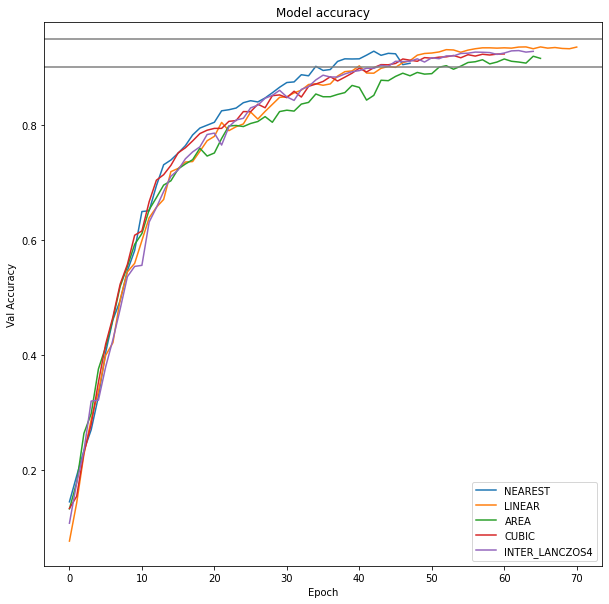

In [19]:
storie = list()
for elem in results:
  hist = elem.history
  storie.append(hist)

#Plot training & validation accuracy values
plt.figure(figsize=(10, 10))
plt.plot(storie[0].history['val_acc'])
plt.plot(storie[1].history['val_acc'])
plt.plot(storie[2].history['val_acc'])
plt.plot(storie[3].history['val_acc'])
plt.plot(storie[4].history['val_acc'])
plt.axhline(0.9, color="grey") # Horizontal line adding the threshold
plt.axhline(0.95, color="grey") # Horizontal line adding the threshold
plt.title('Model accuracy')
plt.ylabel('Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['NEAREST', 'LINEAR', 'AREA', 'CUBIC', 'INTER_LANCZOS4'], loc='lower right')
plt.show()

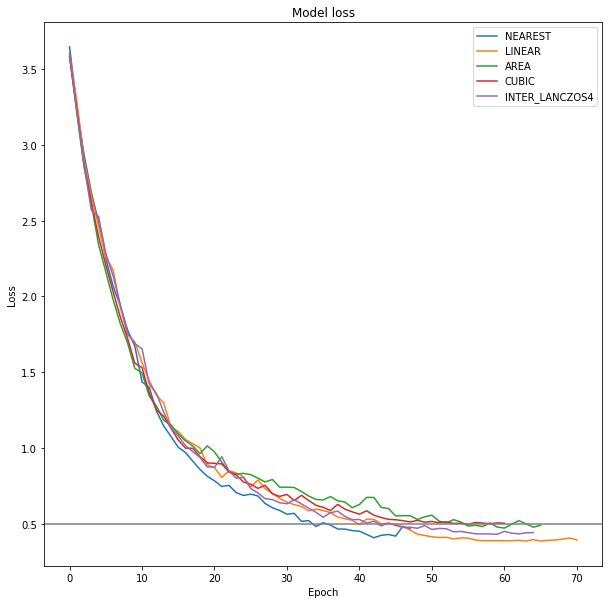

In [21]:
#Plot training & validation accuracy values
plt.figure(figsize=(10, 10))
plt.plot(storie[0].history['val_loss'])
plt.plot(storie[1].history['val_loss'])
plt.plot(storie[2].history['val_loss'])
plt.plot(storie[3].history['val_loss'])
plt.plot(storie[4].history['val_loss'])
plt.axhline(0.5, color="grey") # Horizontal line adding the threshold
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['NEAREST', 'LINEAR', 'AREA', 'CUBIC', 'INTER_LANCZOS4'], loc='upper right')
plt.show()